In [ ]:
# !pip install -q torch transformers transformers accelerate bitsandbytes langchain sentence-transformers faiss-gpu openpyxl pacmap datasets langchain-community ragatouille

In [31]:
from tqdm.notebook import tqdm
import pandas as pd
import numpy as np
from typing import Optional, List, Tuple
import matplotlib.pyplot as plt

pd.set_option("display.max_colwidth", None)  # This will be helpful when visualizing retriever outputs

In [2]:
from dotenv import load_dotenv
from time import sleep
import os
import json

load_dotenv()  # take environment variables from .env.

True

In [6]:
# establish a connection to the PostgreSQL database
import psycopg2 as pg

conn = pg.connect(
    dbname=os.environ["POSTGRES_DB_VECTOR"],
    user=os.environ["POSTGRES_USER"],
    password=os.environ["POSTGRES_PASSWORD"],
    host=os.environ["POSTGRES_HOST"]
)

In [7]:
from langchain_openai import OpenAIEmbeddings

embeddings_model = "text-embedding-3-large"
dimensions = 256
embeddings = OpenAIEmbeddings(model=embeddings_model, dimensions=dimensions)

In [8]:
from langchain_postgres import PGVector
from langchain_postgres.vectorstores import PGVector, DistanceStrategy

# See docker command above to launch a postgres instance with pgvector enabled.
connection = f'postgresql+psycopg://{os.environ["POSTGRES_USER"]}:{os.environ["POSTGRES_PASSWORD"]}@{os.environ["POSTGRES_HOST"]}:5432/{os.environ["POSTGRES_DB_VECTOR"]}'  # Uses psycopg3!
collection_name = "all_properties"

# https://api.python.langchain.com/en/latest/vectorstores/langchain_postgres.vectorstores.PGVector.html

vector_store = PGVector(
    embeddings=embeddings,
    embedding_length=dimensions,
    distance_strategy=DistanceStrategy.COSINE,
    collection_name=collection_name,
    connection=connection,
    use_jsonb=True
)

In [29]:
df = pd.read_sql_query(
    """
    SELECT
        embedding,
        cmetadata->>'property_id' as property_id,
        cmetadata->>'property_name' as property_name,
        cmetadata->>'property_description' as property_description,
        cmetadata->>'entity_class' as entity_class,
        cmetadata->>'entity_subclass' as entity_subclass,
        cmetadata->>'target_class' as target_class
    FROM langchain_pg_embedding WHERE collection_id = '9d70e7bc-099d-467c-a7e7-312345b411bd' LIMIT 1000;
    """, conn)

/tmp/ipykernel_284423/993173503.py:1: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(


In [30]:
df.head()

,embedding,property_id,property_name,property_description,entity_class,entity_subclass,target_class
0,"[-0.005819867,0.07133708,-0.03466942,0.046991885,-0.0656088,0.07546677,-0.01654374,-0.074334435,0.033204045,-0.118162446,0.060779724,0.111634865,-0.10044474,-0.030073475,-0.045493208,-0.00024665744,-0.024611626,0.0647762,-0.056483515,0.02331277,0.05225391,0.07813109,-0.09205214,0.08525813,0.09618183,0.009849645,-0.026160259,0.0051454618,-0.045393296,-0.005520131,-0.00155696,-0.038299553,0.06680774,0.0043877964,0.025194444,-0.053219724,-0.026276823,-0.015577926,0.008109514,-0.04166325,0.08385937,-0.15945935,-0.14400631,0.0521873,0.14920174,0.034835942,-0.033637,-0.016610349,-0.08998729,-0.019632684,-0.014270746,0.010332553,-0.08858853,0.03282105,-0.011056914,0.014953477,0.004483545,-0.05688316,0.043395057,0.07186994,-0.14347345,-0.04849056,-0.0137462085,-0.055584308,-0.022313653,-0.07073761,0.014270746,0.077798046,-0.05864827,-0.06051329,0.0050455495,0.09285144,0.0959154,0.10390835,-0.023112947,0.09012051,-0.022180436,0.04149673,-0.017517881,0.01586101,0.037666775,-0.008442554,0.007947157,0.09131946,-0.1001117,0.02171418,0.0040610014,-0.1421413,-0.020964842,0.0029203407,-0.07033796,-0.06827311,-0.025694003,-0.03255462,-0.011414932,-0.038332857,0.09052016,-0.0028620588,0.0040297788,0.07919681,0.04829074,-0.0137378825,0.02439515,-0.044993646,-0.013987662,-0.06024686,-0.07959646,0.022813212,0.01004947,0.10137725,0.0035302197,-0.04565973,-0.052553646,0.056416906,-0.052020784,0.04299541,-0.08199435,0.04719171,0.070671,-0.049622897,-0.061445802,0.06334413,0.054551885,-0.17890887,0.065575495,0.035368804,-0.1043746,0.083659545,-0.0033387218,0.009791364,0.03903224,0.055151355,-0.006968853,-0.009749734,0.08785584,0.10963663,0.036367923,-0.01160643,0.03372026,-0.023945546,-0.100311525,-0.12715451,-0.041696556,0.07566659,0.05748263,-0.054085627,0.028574796,-0.0075808135,0.04019788,-0.16678622,0.06577532,-0.02009894,-0.021764137,0.04079735,-0.045726333,0.1657205,0.0011271308,-0.06111276,0.015236561,0.062411617,-0.036134794,0.0011687608,-0.03819964,0.0014341517,0.0052079065,0.009924579,-0.0031617945,0.021797441,-0.22699977,0.03500246,-0.026992857,-0.060679812,0.08345972,0.0012239205,-0.050189067,-0.025793916,0.033503782,-0.044394176,-0.020931538,-0.04332845,-0.12888631,-0.023046339,0.03896563,0.08179452,-0.012713786,-0.05478501,0.027542373,-0.0025623234,0.041196994,0.036068186,-0.009691452,0.09245179,0.09125285,0.004046431,0.0008804734,-0.006219514,0.0060904613,-0.09744738,-0.017701054,-0.039598405,0.085924216,-0.12848668,-0.01266383,0.011947795,-0.02263004,0.11070236,-0.015511318,-0.022496823,0.052553646,-0.0011947795,-0.0067274,0.021431098,0.029324135,0.090320334,0.06327752,0.057948887,0.0008294767,-0.039931446,-0.0040068827,-0.05341955,0.06630818,-0.09458324,0.0053411224,0.034136556,-0.03037321,0.07053778,-0.073601745,0.053719286,-0.044993646,0.013887751,0.123224646,0.03593497,-0.020848278,-0.048823602,-0.09738077,0.14000984,0.04642572,-0.09071998,-0.014737002,-0.007293567,-0.062378313,-0.070138134,0.027159378,-0.009266826,0.08965425,-0.047424838,0.08652368,0.017101582,0.052886687,-0.02389559,0.040863957,-0.07559998,0.087522805,-0.028574796,-0.03836616,0.102376364]",5838,hasLoveInterest,The love interests associated with the character.,Character,NPC,String
1,"[-0.017535249,0.010657039,-0.04326106,0.1029777,0.030826297,0.022375125,-0.032855324,-0.055584133,0.026731016,-0.11913545,-0.005156331,0.088309154,-0.07885277,-0.12613465,-0.033990834,-0.012397532,0.045904376,0.0750181,0.013765729,0.020346101,0.00067944435,0.047170192,-0.13313386,0.036392156,0.004095281,0.06284395,0.030007241,-0.044861943,-0.11369989,0.038197804,0.067869976,-0.018121619,-0.06571065,0.017991314,0.002210521,0.017888932,0.024348307,0.06574787,0.030230619,-0.044824712,0.110647045,-0.037453208,-0.10558379,0.011010721,0.065450035,0.000612547,-0.07818264,0.06898687,-0.0410645,0.012853598,0.049739048,0.06392361,-0.055658594,0.031570893,-0.10848772,0.014640629,0.04921783,0.0

In [32]:
df['embedding'] = df.embedding.apply(eval).apply(np.array)

In [ ]:
df['embedding'][0]

In [38]:
# convert df column with a vector to a numnpy 2d array
vectors = np.stack(df['embedding'].values)

/tmp/ipykernel_284423/1360200364.py:19: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colormap = matplotlib.cm.get_cmap('tab20', len(colors))


Text(0.5, 1.0, 'Amazon ratings visualized in language using t-SNE')

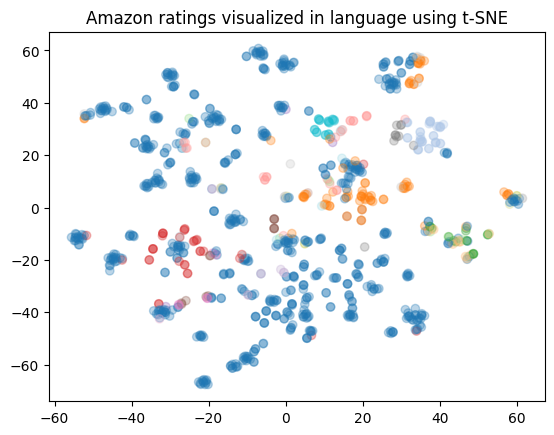

In [40]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib

matrix = vectors

# Create a t-SNE model and transform the data
tsne = TSNE(n_components=2, perplexity=15, random_state=42, init='random', learning_rate=200)
vis_dims = tsne.fit_transform(matrix)

colors = df.entity_class.unique().tolist()

x = [x for x,y in vis_dims]
y = [y for x,y in vis_dims]

color_indices = df.entity_class.apply(lambda x: colors.index(x))

colormap = matplotlib.cm.get_cmap('tab20', len(colors))

plt.scatter(x, y, c=color_indices, cmap=colormap, alpha=0.3)
plt.title("Amazon ratings visualized in language using t-SNE")

In [41]:
import numpy as np
from sklearn.cluster import KMeans

matrix = np.vstack(df.embedding.values)
n_clusters = 20

kmeans = KMeans(n_clusters = n_clusters, init='k-means++', random_state=42)
kmeans.fit(matrix)
df['cluster'] = kmeans.labels_

In [42]:
df.cluster.value_counts()

cluster
14    127
10    104
5     100
2      99
16     55
8      54
7      51
19     47
4      44
0      41
9      38
6      38
3      36
15     32
11     29
1      27
18     25
17     25
13     19
12      9
Name: count, dtype: int64

In [ ]:
query = "property of a game that describes the developer/designer of the game"

results = vector_store.similarity_search_with_score(
    query=query,
    k=50,
    filter={
        "entity_class": {"$in": ['Game']},
        # "target_class": {"$in": ['Location', 'City']}
    }
)
for doc in results:
    print(f"* {doc[1]} {doc[0].page_content} [{doc[0].metadata}]")

In [44]:
import pacmap
import numpy as np
import plotly.express as px

embedding_projector = pacmap.PaCMAP(n_components=2, n_neighbors=None, MN_ratio=0.5, FP_ratio=2.0, random_state=1)

embeddings_2d = matrix

# Fit the data (the index of transformed data corresponds to the index of the original data)
documents_projected = embedding_projector.fit_transform(np.array(embeddings_2d), init="pca")

/home/aleksey/Workspace/GameOntologyProject/venv/lib/python3.10/site-packages/pacmap/pacmap.py:822: UserWarning: Warning: random state is set to 1
  warnings.warn(f'Warning: random state is set to {_RANDOM_STATE}')


In [ ]:
df_plotly = pd.DataFrame.from_dict(
    [
        {
            "x": documents_projected[i, 0],
            "y": documents_projected[i, 1],
            "class": df[i].metadata["entity_class"],
            "extract": RAW_KNOWLEDGE_BASE[:1000][i].page_content[:100],
            "symbol": "circle",
            "size_col": 4,
        }
        for i, doc in df.iterrows())
    ]
)

# Visualize the embedding
fig = px.scatter(
    df_plotly,
    x="x",
    y="y",
    color="source",
    hover_data="extract",
    size="size_col",
    symbol="symbol",
    color_discrete_map={"User query": "black"},
    width=1000,
    height=700,
)
fig.update_traces(
    marker=dict(opacity=1, line=dict(width=0, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
fig.update_layout(
    legend_title_text="<b>Chunk source</b>",
    title="<b>2D Projection of Chunk Embeddings via PaCMAP</b>",
)
fig.show()